# <font color='blue'>Mean Machine -  LASSO and Feature Selection<font>

In this notebook, you will use LASSO to select features. The tasks herewith are to
* run LASSO with different L1 penalties.
* choose best L1 penalty using a validation set.
* choose best L1 penalty using a validation set, with additional constraint on the size of subset.

# 1: Set the path that includes all relevant files

In [1]:
import os                                               # 操作系统用来管理文件路径
os.chdir("C:\Users\stevenwsy\Desktop\Steven - Python")  # 将路径改为 "C:\Users\stevenwsy\Desktop\Steven - Python"

# 注意：你们要把 "C:\Users\stevenwsy\Desktop\Steven - Python" 改成在你们电脑里面的路径

# 2: Import all relevant packages

In [2]:
import numpy as np     # 用来做数学运算
import pandas as pd    # 用来处理数据表

# 将所有图都在 Notebook 里显示
%matplotlib inline               
import matplotlib.pyplot as plt  # 用来画图

from sklearn.linear_model import Lasso                 # 套索回归
from sklearn.cross_validation import train_test_split  # 做交叉验证，划分训练集和测试集

# 3: Load and refine house sales data

In [3]:
sales = pd.read_csv('kc_house_data.csv')
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
sales.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

* Taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.
* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.

In [5]:
sales['sqft_living_sqrt'] = np.sqrt( sales['sqft_living'] )
sales['sqft_lot_sqrt'] = np.sqrt( sales['sqft_lot'] )
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_sqrt,sqft_lot_sqrt,bedrooms_square,floors_square
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,98178,47.5112,-122.257,1340,5650,34.351128,75.166482,9,1.0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,50.695167,85.099941,9,4.0
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,0,98028,47.7379,-122.233,2720,8062,27.748874,100.000000,4,1.0
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,98136,47.5208,-122.393,1360,5000,44.271887,70.710678,16,1.0
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,98074,47.6168,-122.045,1800,7503,40.987803,89.888820,9,1.0


# 4: Basic Function

In [6]:
def lasso_regression( input, output, l1_penalty ):
    model = Lasso( alpha=l1_penalty, normalize=False )
    model.fit( input.values, output.values )
    return model

In [7]:
def print_coefficients( model, features ):        
    w = list( np.hstack((model.intercept_,model.coef_)) )
    labels = ['intercept'] + features
    df = pd.DataFrame({'name': labels, 'value': w})
    return df

# 5: LASSO regression

Let us fit a model with all the features available, plus the features we just created above.

In [8]:
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the Lasso call in sklearn.

In [10]:
input = sales[ all_features ]
output = sales[ 'price' ]
l1_penalty = 1e2
model = lasso_regression( input, output, l1_penalty )
print_coefficients( model, all_features )

,name,value
0,intercept,6.495871e+06
1,bedrooms,-1.861398e+04
2,bedrooms_square,4.486137e+02
3,bathrooms,5.116391e+04
4,sqft_living,2.966845e+02
5,sqft_living_sqrt,-4.390465e+04
6,sqft_lot,6.891447e-01
7,sqft_lot_sqrt,-6.724721e+02
8,floors,-8.159588e+04
9,floors_square,2.879482e+04


# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [11]:
(training_and_validation, test) = train_test_split( sales, 
                                  train_size=0.9, random_state=0 )
(training, validation) = train_test_split( training_and_validation, 
                         train_size=0.5, random_state=0 )

Next, we write a loop that does the following:
* For `l1_penalty` in $[10^{-1}, 10^{-0.5}, 10^0, 10^{0.5}, ..., 10^5]$ (to get this in Python, type `np.logspace(-1, 5, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. 
    * Compute the RSS on VALIDATION data for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

In [12]:
input = training[ all_features ]
output = training[ 'price' ]
valid_error = list()
l1_penalty_set = np.logspace(-1, 5, num=13)

for l1_penalty in l1_penalty_set:
    model = lasso_regression( input, output, l1_penalty )
    y_true = validation['price'].values
    y_pred = model.predict( validation[all_features].values )
    i_valid_error = ((y_true- y_pred)**2).sum()
    valid_error.append( i_valid_error )
    print "lambda: %.3f, validation error: %.10e" %(l1_penalty, i_valid_error)

lambda: 0.100, validation error: 4.4191217519e+14
lambda: 0.316, validation error: 4.4190716451e+14
lambda: 1.000, validation error: 4.4189133042e+14
lambda: 3.162, validation error: 4.4184136926e+14
lambda: 10.000, validation error: 4.4168448461e+14
lambda: 31.623, validation error: 4.4119943586e+14
lambda: 100.000, validation error: 4.3977621761e+14
lambda: 316.228, validation error: 4.3638201320e+14
lambda: 1000.000, validation error: 4.3869549219e+14
lambda: 3162.278, validation error: 4.5534912903e+14
lambda: 10000.000, validation error: 4.6872407471e+14
lambda: 31622.777, validation error: 5.1582984541e+14
lambda: 100000.000, validation error: 6.3939353964e+14


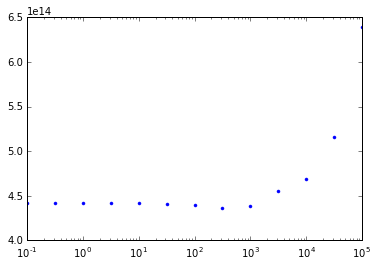

In [13]:
# Plot the l1_penalty values in the x axis and 
# the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.
plt.xscale('log')
plt.plot( l1_penalty_set, valid_error, '.' )

In [14]:
best_valid_error = min(valid_error)
best_l1_penalty = l1_penalty_set[ np.argmin(valid_error) ]
print "best lambda: %.3f, best validation error: %.10e" \
%(best_l1_penalty, best_valid_error)
print 'test error:', ((test['price'].values \
                     - model.predict( test[all_features].values ))**2).sum()

best lambda: 316.228, best validation error: 4.3638201320e+14
test error: 1.20380759013e+14


In [15]:
model = lasso_regression( input, output, best_l1_penalty )
print_coefficients( model, all_features )

,name,value
0,intercept,6.798913e+06
1,bedrooms,2.058058e+03
2,bedrooms_square,-2.045542e+03
3,bathrooms,5.594565e+04
4,sqft_living,2.882006e+02
5,sqft_living_sqrt,-4.380254e+04
6,sqft_lot,5.812723e-01
7,sqft_lot_sqrt,-5.747392e+02
8,floors,-3.241113e+04
9,floors_square,1.785524e+04


# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [16]:
max_nonzeros = 7 # suppose we aim for 7 features

input = training[ all_features ]
output = training[ 'price' ]

nonzero_list = list()
l1_penalty_set = np.logspace(4, 7, num=20)

for l1_penalty in l1_penalty_set :
    model = lasso_regression( input, output, l1_penalty )
    w = np.hstack((model.intercept_,model.coef_))
    i_nonzero = sum(w != 0)
    nonzero_list.append( i_nonzero )
    print "When lambda is %.3f, the number of non-zeros is %d" %(l1_penalty, i_nonzero)

When lambda is 10000.000, the number of non-zeros is 15
When lambda is 14384.499, the number of non-zeros is 13
When lambda is 20691.381, the number of non-zeros is 13
When lambda is 29763.514, the number of non-zeros is 13
When lambda is 42813.324, the number of non-zeros is 11
When lambda is 61584.821, the number of non-zeros is 10
When lambda is 88586.679, the number of non-zeros is 8
When lambda is 127427.499, the number of non-zeros is 8
When lambda is 183298.071, the number of non-zeros is 8
When lambda is 263665.090, the number of non-zeros is 7
When lambda is 379269.019, the number of non-zeros is 7
When lambda is 545559.478, the number of non-zeros is 7
When lambda is 784759.970, the number of non-zeros is 7
When lambda is 1128837.892, the number of non-zeros is 6
When lambda is 1623776.739, the number of non-zeros is 6
When lambda is 2335721.469, the number of non-zeros is 5
When lambda is 3359818.286, the number of non-zeros is 4
When lambda is 4832930.239, the number of non

Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzero` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzero` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)

In [17]:
diff =  np.asarray(nonzero_list) - max_nonzeros
idx1 = sum(diff > 0)
idx2 = len(diff) - sum(diff<0)
l1_penalty_min = l1_penalty_set[idx1-1]
l1_penalty_max = l1_penalty_set[idx2]
print "the min and max of penalty is %.3f and %.3f" %(l1_penalty_min, l1_penalty_max)

the min and max of penalty is 183298.071 and 1128837.892


## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [18]:
input = training[ all_features ]
output = training[ 'price' ]

valid_error = list()
nonzero_list = list()
l1_penalty_set = np.linspace( l1_penalty_min, l1_penalty_max, 20 )

for l1_penalty in l1_penalty_set:
    model = lasso_regression( input, output, l1_penalty )
    
    w = np.hstack((model.intercept_,model.coef_))
    i_nonzero = sum(w != 0)
    nonzero_list.append( i_nonzero )
    
    y_true = validation['price'].values
    y_pred = model.predict( validation[all_features].values )
    
    i_valid_error = ((y_true- y_pred)**2).sum()
    valid_error.append( i_valid_error )
    
    print "lambda: %.3f, validation error: %.10e, the number of non-zeros is %d" \
    %(l1_penalty, i_valid_error, i_nonzero)

lambda: 183298.071, validation error: 6.3227175434e+14, the number of non-zeros is 8
lambda: 233063.325, validation error: 6.3652334979e+14, the number of non-zeros is 7
lambda: 282828.579, validation error: 6.3725591099e+14, the number of non-zeros is 7
lambda: 332593.832, validation error: 6.3812241915e+14, the number of non-zeros is 7
lambda: 382359.086, validation error: 6.3912259024e+14, the number of non-zeros is 7
lambda: 432124.340, validation error: 6.4025727049e+14, the number of non-zeros is 7
lambda: 481889.593, validation error: 6.4152653936e+14, the number of non-zeros is 7
lambda: 531654.847, validation error: 6.4293037578e+14, the number of non-zeros is 7
lambda: 581420.101, validation error: 6.4446880704e+14, the number of non-zeros is 7
lambda: 631185.355, validation error: 6.4614182889e+14, the number of non-zeros is 7
lambda: 680950.608, validation error: 6.4794943214e+14, the number of non-zeros is 7
lambda: 730715.862, validation error: 6.4986386706e+14, the numbe

In [19]:
diff =  np.asarray(nonzero_list) - max_nonzeros
idx1 = sum(diff > 0)
idx2 = len(diff) - sum(diff<0)
l1_penalty_subset = l1_penalty_set[idx1:idx2]
sub_valid_error = valid_error[idx1:idx2]
best_valid_error = min(sub_valid_error)
best_l1_penalty = l1_penalty_subset[ np.argmin(sub_valid_error) ]

print "best lambda: %.3f, best validation error: %.10e" \
%(best_l1_penalty, best_valid_error)

best lambda: 233063.325, best validation error: 6.3652334979e+14


In [20]:
model = lasso_regression( input, output, best_l1_penalty )
print_coefficients( model, all_features )

,name,value
0,intercept,4.228926e+06
1,bedrooms,-0.000000e+00
2,bedrooms_square,-0.000000e+00
3,bathrooms,0.000000e+00
4,sqft_living,2.779912e+02
5,sqft_living_sqrt,-0.000000e+00
6,sqft_lot,8.232036e-01
7,sqft_lot_sqrt,-7.671904e+02
8,floors,0.000000e+00
9,floors_square,0.000000e+00
